MIE451/1513 Decision Support System -- Sentiment Analysis Lab
===

## Packages

### type: pip install twython -y

In [1]:
import sys
print(sys.version)

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
!pip install twython

In [3]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Simple Examples

In [0]:
#Example sentences
sentences = ["VADER is smart, handsome, and funny.",
            "Professor Scott is a great professor with excellent teaching skills and research ability",
            "Eldan is a good programmer, he is very good at python and Java",
            "George is a good programmer, he is good at Java and C++ but not doing that well in python",
            "MIEXXX is such a boring course, the projects are too long to finish",
            "MIE451 is a very intersting course which taught by a great professor and very useful knowledge"]

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [6]:
evalSentences(sentences)

100%|██████████| 6/6 [00:00<00:00, 700.22it/s]

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 
Professor Scott is a great professor with excellent teaching skills and research ability
compound: 0.8779, neg: 0.0, neu: 0.471, pos: 0.529, 
Eldan is a good programmer, he is very good at python and Java
compound: 0.7003, neg: 0.0, neu: 0.633, pos: 0.367, 
George is a good programmer, he is good at Java and C++ but not doing that well in python
compound: 0.1727, neg: 0.105, neu: 0.71, pos: 0.185, 
MIEXXX is such a boring course, the projects are too long to finish
compound: -0.3182, neg: 0.173, neu: 0.827, pos: 0.0, 
MIE451 is a very intersting course which taught by a great professor and very useful knowledge
compound: 0.807, neg: 0.0, neu: 0.622, pos: 0.378, 


# Working on Real social Network Data

## Load Data

In [0]:
#Read in from pandas
hotelDf = pandas.read_csv('https://github.com/MIE451-1513-2019/course-datasets/raw/master/markham.csv')
hotelDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [8]:
hotelDf.head()

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,86280330,markham\ca\181720\181948\107186787.html,Staybridge Suites Toronto,my husband and i stayed there for 9 nights as ...,4,positive
1,85071982,markham\ca\181720\181948\107186787.html,Staybridge Suites Toronto,Our stay was not the worst I've ever stayed in...,3,negative
2,79574338,markham\ca\181720\181948\107186787.html,Staybridge Suites Toronto,I stayed here during a weeknight in July with ...,3,negative
3,78931757,markham\ca\181720\181948\107186787.html,Staybridge Suites Toronto,Spent 5 weeks here while my home was prepped -...,5,positive
4,78277874,markham\ca\181720\181948\107186787.html,Staybridge Suites Toronto,My family booked this hotel and at first we we...,5,positive


## Sentiment Analysis

In [0]:
reviews = hotelDf['reviewColumn'].values

In [0]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 3894/3894 [00:04<00:00, 873.42it/s] 


In [0]:
reviewDF.head()

,reviewCol,vader
0,my husband and i stayed there for 9 nights as ...,0.9731
1,Our stay was not the worst I've ever stayed in...,-0.2973
2,I stayed here during a weeknight in July with ...,-0.6042
3,Spent 5 weeks here while my home was prepped -...,0.9537
4,My family booked this hotel and at first we we...,0.9985


## Find most sentimental words by Mutual Information

### Data Preprocessing
1. Find Topk words (No preprocessing steps now)
2. Reconstruct the above dataframe into CSV style..

In [0]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=500)

In [0]:
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,room,hotel,staff,stay,breakfast,...,appointed,stays,set,attentive,glass,zoo,thanks,job,welcome,wish
0,Staybridge Suites Toronto,4,positive,my husband and i stayed there for 9 nights as ...,0.9731,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Staybridge Suites Toronto,3,negative,Our stay was not the worst I've ever stayed in...,-0.2973,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Staybridge Suites Toronto,3,negative,I stayed here during a weeknight in July with ...,-0.6042,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Staybridge Suites Toronto,5,positive,Spent 5 weeks here while my home was prepped -...,0.9537,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Staybridge Suites Toronto,5,positive,My family booked this hotel and at first we we...,0.9985,1,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0


### Compute Mutual Information

#### Mutual Information

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
miScoredf = getMI(topk, finaldf)

In [0]:
miScoredf.head()

,Word,MI Score
152,told,0.017627
7,great,0.016604
6,clean,0.014867
162,said,0.014862
373,poor,0.013762


#### Pairwise Mutual Information

show case

In [0]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
pmiCal(finaldf,'hampton')

,x,y,px,py,pxy,pmi
0,positive,0,0.778891,0.979199,0.761428,-0.001655
1,positive,1,0.778891,0.020801,0.017463,0.074943
2,negative,0,0.221109,0.979199,0.217771,0.005807
3,negative,1,0.221109,0.020801,0.003338,-0.320402


In [0]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [0]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████| 500/500 [00:10<00:00, 56.28it/s]


In [0]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
206,highly,0.222929
251,loved,0.212980
474,awesome,0.200492
496,thanks,0.195076
297,love,0.192726


In [0]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
475,finally,1.175325
373,poor,1.158237
327,smell,1.057113
152,told,1.018110
385,loud,0.974421


In [0]:
#Complete pmi dataframe
pmidf.head()

,word,pmi
0,room,x y px py pxy ...
1,hotel,x y px py pxy ...
2,staff,x y px py pxy ...
3,stay,x y px py pxy ...
4,breakfast,x y px py pxy ...


In [0]:
#To access pmi matrix for a specific word
pmidf[pmidf['word']=='room']['pmi'][0]

,x,y,px,py,pxy,pmi
0,positive,0,0.778891,0.365177,0.306626,0.075129
1,positive,1,0.778891,0.634823,0.472265,-0.045921
2,negative,0,0.221109,0.365177,0.058552,-0.321376
3,negative,1,0.221109,0.634823,0.162558,0.146785


## Analysis over all items

In [0]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

### Top K words comparison between ground truth reviews and vader predicted reviews

In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [0]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=10, label_value='positive')

In [0]:
topkGroundPos

[('clean', 1823),
 ('breakfast', 1785),
 ('good', 1685),
 ('great', 1659),
 ('nice', 1367),
 ('would', 1135),
 ('stayed', 1085),
 ('area', 1078),
 ('friendly', 1032),
 ('well', 944)]

In [0]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=10, label_value='negative')

In [0]:
topkGroundNeg

[('breakfast', 521),
 ('would', 503),
 ('one', 494),
 ('good', 476),
 ('night', 420),
 ('desk', 395),
 ('front', 361),
 ('area', 359),
 ('get', 342),
 ('stayed', 339)]

In [0]:
topkVaderPos = getTopK(df=itemAnalysisDf, 
                       k=10, 
                       label_value=0, 
                       label_column='vader', 
                       operation=operator.gt)

In [0]:
topkVaderPos

[('breakfast', 2156),
 ('clean', 2067),
 ('good', 2054),
 ('great', 1815),
 ('nice', 1607),
 ('would', 1455),
 ('area', 1329),
 ('stayed', 1297),
 ('one', 1253),
 ('friendly', 1156)]

In [0]:
topkVaderNeg = getTopK(df=itemAnalysisDf, 
                       k=10, 
                       label_value=0, 
                       label_column='vader', 
                       operation=operator.lt)

In [0]:
topkVaderNeg

[('would', 180),
 ('night', 167),
 ('one', 164),
 ('desk', 164),
 ('front', 153),
 ('breakfast', 149),
 ('service', 132),
 ('stayed', 127),
 ('get', 126),
 ('bed', 123)]

## Hotel Ranking

In [0]:
#Extract a list of hotels
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Staybridge Suites Toronto', 'Comfort Inn Toronto Northeast',
       'Hilton Toronto / Markham Suites Conference Centre &amp; Spa',
       'Courtyard Toronto Northeast/Markham', 'Delta Markham',
       'Park Inn By Radisson Toronto-Markham',
       'Monte Carlo Inn &amp; Suites Downtown Markham',
       'Residence Inn Toronto Markham', 'Courtyard Toronto Markham',
       'Monte Carlo Inns Markham', 'Hilton Garden Inn Toronto/Markham',
       'Hampton Inn &amp; Suites by Hilton Toronto Markham',
       'Homewood Suites by Hilton Toronto-Markham',
       'TownePlace Suites Toronto Northeast/Markham',
       'Edward Village Markham'], dtype=object)

In [0]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [0]:
hotelRatingDfGt = getHotelRank(finaldf)

In [0]:
hotelRatingDfGt.head()

,hotelName,avgRatingScore
11,Hampton Inn &amp; Suites by Hilton Toronto Mar...,4.447458
13,TownePlace Suites Toronto Northeast/Markham,4.351351
10,Hilton Garden Inn Toronto/Markham,4.305927
12,Homewood Suites by Hilton Toronto-Markham,4.303398
3,Courtyard Toronto Northeast/Markham,4.300813


In [0]:
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')

In [0]:
hotelRatingDfVd.head()

,hotelName,avgRatingScore
13,TownePlace Suites Toronto Northeast/Markham,0.835615
11,Hampton Inn &amp; Suites by Hilton Toronto Mar...,0.835335
6,Monte Carlo Inn &amp; Suites Downtown Markham,0.831920
3,Courtyard Toronto Northeast/Markham,0.807440
14,Edward Village Markham,0.803865


# Results Display

## Histograms

In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

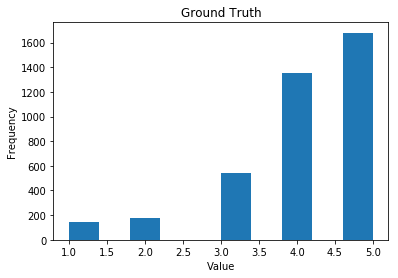

In [0]:
getHistogram('ratingScore', 'Ground Truth')

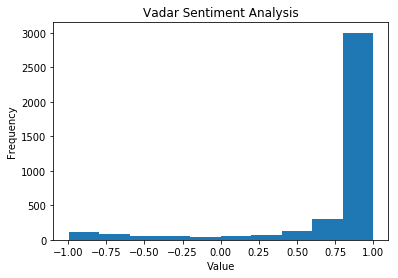

In [0]:
getHistogram('vader', 'Vadar Sentiment Analysis')

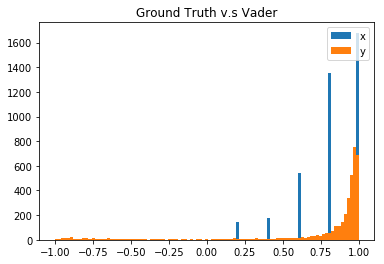

In [0]:
getHistogram('both', 'Ground Truth v.s Vader')

In [0]:
tpdf = pandas.DataFrame(topkGroundPos)
tndf = pandas.DataFrame(topkGroundNeg)
tpdf.columns =['word','count']
tndf.columns =['word','count']
tpdf['type'] = 'Positive'
tndf['type'] = 'Negative'
overlayhist = pandas.concat([tpdf,tndf])
overlayhist

,word,count,type
0,clean,1823,Positive
1,breakfast,1785,Positive
2,good,1685,Positive
3,great,1659,Positive
4,nice,1367,Positive
5,would,1135,Positive
6,stayed,1085,Positive
7,area,1078,Positive
8,friendly,1032,Positive
9,well,944,Positive


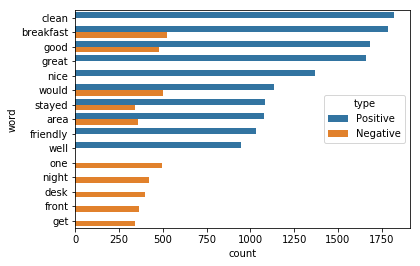

In [0]:
sns.barplot(x="count", y='word', hue='type', data=overlayhist)

## Box Plots

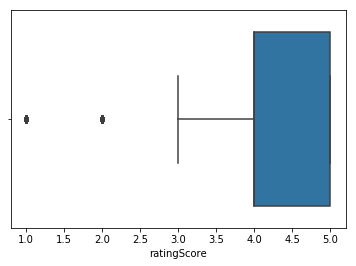

In [0]:
data = finaldf['ratingScore']
sns.boxplot(data)

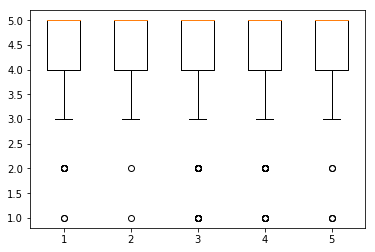

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

hampton = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
towneplace = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
hiltonGarden = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
homewood = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
courtyard = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [hampton, towneplace, hiltonGarden, homewood, courtyard]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

## Scatter Plots

Text(0.5, 0, 'Vader Score')

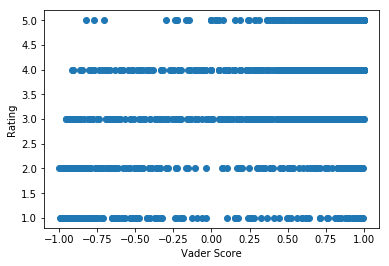

In [0]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [0]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

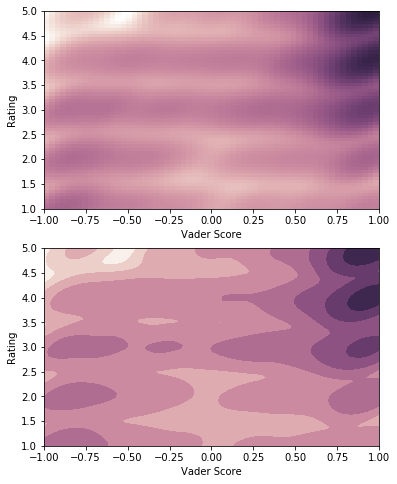

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

# Norn Phrase Example

In [0]:
# Sample text
text = """The Buddha, the Godhead, resides quite as comfortably in the circuits of a digital
computer or the gears of a cycle transmission as he does at the top of a mountain
or in the petals of a flower. To think otherwise is to demean the Buddha...which is
to demean oneself."""

In [0]:
tagger = PerceptronTagger()

In [0]:
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag
taggedToks = pos_tag(re.findall(r'\w+', text))
taggedToks

[('The', 'DT'),
 ('Buddha', 'NNP'),
 ('the', 'DT'),
 ('Godhead', 'NNP'),
 ('resides', 'VBZ'),
 ('quite', 'RB'),
 ('as', 'IN'),
 ('comfortably', 'RB'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('circuits', 'NNS'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('digital', 'JJ'),
 ('computer', 'NN'),
 ('or', 'CC'),
 ('the', 'DT'),
 ('gears', 'NNS'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('cycle', 'NN'),
 ('transmission', 'NN'),
 ('as', 'IN'),
 ('he', 'PRP'),
 ('does', 'VBZ'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('top', 'NN'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('mountain', 'NN'),
 ('or', 'CC'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('petals', 'NNS'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('flower', 'NN'),
 ('To', 'TO'),
 ('think', 'VB'),
 ('otherwise', 'RB'),
 ('is', 'VBZ'),
 ('to', 'TO'),
 ('demean', 'VB'),
 ('the', 'DT'),
 ('Buddha', 'NNP'),
 ('which', 'WDT'),
 ('is', 'VBZ'),
 ('to', 'TO'),
 ('demean', 'VB'),
 ('oneself', 'PRP')]

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

### Google: https://www.researchgate.net/figure/282542411_fig2_Figure-4-Parse-tree-enrichment-examples-a-Unmodified-SPT-The-non-terminal-node


In [0]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)
tree= chunker.parse(taggedToks)

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Traverse tree and get noun phrases
npTokenList = [word for word in get_terms(tree)]

npTokenList

[['digit', 'comput'], ['cycl', 'transmiss']]

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
finalList = flatten(npTokenList)

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF)

In [0]:
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,room tip,front desk,front desk staff,free breakfast,bedroom suit,...,night stay,breakfast area,comfort inn,downtown toronto,free wifi,hampton inn,full kitchen,great stay,great locat,mont carlo inn
0,Staybridge Suites Toronto,4,positive,my husband and i stayed there for 9 nights as ...,0.9731,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Staybridge Suites Toronto,3,negative,Our stay was not the worst I've ever stayed in...,-0.2973,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Staybridge Suites Toronto,3,negative,I stayed here during a weeknight in July with ...,-0.6042,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Staybridge Suites Toronto,5,positive,Spent 5 weeks here while my home was prepped -...,0.9537,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Staybridge Suites Toronto,5,positive,My family booked this hotel and at first we we...,0.9985,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [0]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf_phrase, topk=topk_phrase)

100%|██████████| 50/50 [00:00<00:00, 71.95it/s]


In [0]:
pmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
12,easi access,0.234617
47,great stay,0.225192
46,full kitchen,0.201095
29,great hotel,0.189260
37,major highway,0.164727


In [0]:
pmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
16,next day,0.998272
14,next morn,0.815951
42,comfort inn,0.815951
25,custom servic,0.778210
1,front desk,0.554148
